In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import swifter

from unicodedata import normalize
from unicodedata import normalize

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

Data Source: https://www.kaggle.com/competitions/mercari-price-suggestion-challenge/data

Kaggle API: `kaggle competitions download -c mercari-price-suggestion-challenge`

#### Utils

In [2]:
# utils for cleaning text in brand_name and category_name

def normalize_text(text):
    '''
    Handles diacritic marks, superscripts and subscripts.
    Returns the text in lowercase.
    '''
    text = text.replace('–', '-').strip()
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode("utf-8").lower()
    return text   
    
def pre_process_brand(text):
    text = expand_contractions(text)
    clean_text = normalize_text(text)#.replace(' ', '_')
    clean_text = re.sub('[^A-Za-z0-9\/]+', ' ', clean_text)
    clean_text = remove_stopwords(clean_text)
    return clean_text

___

In [3]:
data_path = 'data/'
data_file_name = 'mercari_eda_cleaned.csv'
data_full_path = data_path + data_file_name

product_listings_mercari = pd.read_csv(data_full_path, keep_default_na=False)
product_listings_mercari.shape

(1481661, 12)

In [4]:
product_listings_mercari.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,men,tops,t-shirts,mlb cincinnati reds shirt size xl,description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,electronics,computers & tablets,components & parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,women,tops & blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,home,home decor,home decor accents,leather horse statues,new tags leather horses retail stand foot high...
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity


In [5]:
product_listings_mercari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481661 entries, 0 to 1481660
Data columns (total 12 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   train_id                  1481661 non-null  int64  
 1   name                      1481661 non-null  object 
 2   item_condition_id         1481661 non-null  int64  
 3   brand_name                1481661 non-null  object 
 4   price                     1481661 non-null  float64
 5   shipping                  1481661 non-null  int64  
 6   item_description          1481661 non-null  object 
 7   main_cat                  1481661 non-null  object 
 8   sub_cat1                  1481661 non-null  object 
 9   sub_cat2                  1481661 non-null  object 
 10  preprocessed_name         1481661 non-null  object 
 11  preprocessed_description  1481661 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 135.7+ MB


In [6]:
product_listings_mercari.replace('missing', np.NaN).isnull().sum()

train_id                         0
name                             0
item_condition_id                0
brand_name                  632336
price                            0
shipping                         0
item_description                 0
main_cat                      6314
sub_cat1                      6314
sub_cat2                      6314
preprocessed_name               78
preprocessed_description       764
dtype: int64

In [7]:
# checking if it's possible to impute some missing brands using the text from name and description
product_listings_mercari['name'] = product_listings_mercari['name'].map(normalize_text)
product_listings_mercari['brand_name'] = product_listings_mercari['brand_name'].map(normalize_text)

unique_brands = list(product_listings_mercari['brand_name'].unique())
unique_brands.remove('missing')
contains_filter = ' | '.join(unique_brands)

contains_filter = ' ' + contains_filter + ' '
contains_filter

" razer | target | acacia swimwear | soffe | nike | smashbox | victoria's secret | rue | scholastic | ugg australia | tarte | wet n wild | too faced | anthropologie | torrid | samsung | forever 21 | air jordan | apple | lularoe | hollister | pink | sephora | under armour | xbox | kylie cosmetics | the north face | brandy melville | lululemon athletica | michael kors | rae dunn | infantino | levi's | patagonia | barbie | h&m | adidas | nostalgia electrics | littlest pet shop | sea wees | motherhood maternity | melissa & doug | pokemon | nintendo | silver jeans co. | spin master | gap | lululemon | rock revival | fossil | merona | boulevard boutique | marc jacobs | steve madden | no boundaries | faded glory | miss me | salvatore ferragamo | urban outfitters | bath & body works | nars | manolo blahnik | ralph lauren | lc lauren conrad | kate spade | elmers | leap frog | beautyblender | pandora | sony | aerie | guess | younique | marucci | cherokee | calvin klein | hamilton beach | eos | d

In [9]:
# listings where brand is missing but the description includes an existing brand
df = product_listings_mercari.copy()
df['name'] = df['name'].apply(lambda x: x.center(len(x)+2))                                   
df.loc[df['brand_name']=='missing'][df['name'].str.contains(contains_filter)]

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description
0,0,mlb cincinnati reds t shirt size xl,3,missing,10.0,1,No description yet,men,tops,t-shirts,mlb cincinnati reds shirt size xl,description yet
17,17,new: baby k'tan active baby carrier,1,missing,29.0,1,Brand new in box Size: Medium Color: Coral Ret...,kids,gear,backpacks & carriers,new baby k tan active baby carrier,brand new box size medium color coral retails ...
31,31,"new lularoe os leggings, stars",1,missing,50.0,1,No description yet,women,athletic apparel,"pants, tights, leggings",new lularoe os leggings stars,description yet
34,34,four puppy dog stuffed animal ty,3,missing,5.0,1,2 beanie babies pugsley wrinkles Puppy with pu...,kids,toys,stuffed animals & plush,four puppy dog stuffed animal ty,2 beanie babies pugsley wrinkles puppy pumpkin...
43,43,apricot beige stick foundation!!,1,missing,12.0,1,Great quality!!! Fast free shipping!! You can ...,beauty,makeup,face,apricot beige stick foundation,great quality fast free shipping find beautifu...
...,...,...,...,...,...,...,...,...,...,...,...,...
1481644,1482518,brooches: lot of 5 assorted (1 coro),3,missing,10.0,1,3 appear to be VTG. The pink one is Coro.,vintage & collectibles,jewelry,brooch,brooches lot 5 assorted 1 coro,3 appear vtg pink one coro
1481648,1482522,lg k7/tribute 5 hybrid case,1,missing,8.0,1,"Perfect Design for LG Tribute 5 / LG K7, NOT f...",electronics,cell phones & accessories,"cases, covers & skins",lg k7/tribute 5 hybrid case,perfect design lg tribute 5 / lg k7 fit lg tri...
1481653,1482527,blk/white ribbed mock neck bodysuit m,1,missing,10.0,1,Brand new black and white ribbed mock neck bod...,women,tops & blouses,blouse,blk/white ribbed mock neck bodysuit,brand new black white ribbed mock neck bodysuit
1481658,1482532,21 day fix containers and eating plan,2,missing,12.0,0,"Used once or twice, still in great shape.",sports & outdoors,exercise,fitness accessories,21 day fix containers eating plan,used twice still great shape


In [10]:
# it looks llike some missing values could be imputed from the listings name
# I will only check in name because item_description might include comparison with other brands and introduce noise

In [11]:
# dict of brand with frequency
brand_freq = dict(product_listings_mercari["brand_name"].value_counts())
exclude_brand = ['missing', 'so', 'pink', 'and', 'all', 'key', 'x', 'm', 'ring', 'lot', 'bike', 'ball', 'complete', 'silver', 'duo', 'pro', 'boots']

for b in exclude_brand:
    brand_freq.pop(b)

# list of brands sorted by frequency
unique_brands = sorted(brand_freq, key=brand_freq.get, reverse=True)

In [12]:
# approach 1: impute brand by checking if text contains an existing brand
def impute_brand1(row, unique_brands):
    # adding ' ' to avoid matching 'x' in 'mix', for example.
    brand_name = row['brand_name']

    # impute only if current brand_name is 'missing'
    if(brand_name=='missing'):
        listing_name = ' ' + row['name'] + ' '
        #item_description = ' ' + row['item_description'] + ' '
        
        for brand in unique_brands:
            brand = ' ' + brand + ' '
            if(brand in listing_name):
                brand_name = brand.strip()
                break
                
    return brand_name

In [307]:
%time product_listings_mercari['brand_approach1'] = product_listings_mercari.swifter.apply(lambda row: impute_brand1(row, unique_brands), axis=1)

Pandas Apply:   0%|          | 0/1481661 [00:00<?, ?it/s]

CPU times: user 4min 50s, sys: 2.15 s, total: 4min 52s
Wall time: 4min 52s


In [308]:
product_listings_mercari.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description,brand_approach1,brand_approach222,brand_approach3
0,0,mlb cincinnati reds t shirt size xl,3,missing,10.0,1,no description yet,men,tops,t-shirts,mlb cincinnati reds shirt size xl,description yet,mlb,mlb,mlb
1,1,razer blackwidow chroma keyboard,3,razer,52.0,0,this keyboard is in great condition and works ...,electronics,computers & tablets,components & parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...,razer,razer,razer
2,2,ava-viv blouse,1,target,10.0,1,adorable top with a hint of lace and a key hol...,women,tops & blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...,target,target,target
3,3,leather horse statues,1,missing,35.0,1,new with tags. leather horses. retail for [rm]...,home,home decor,home decor accents,leather horse statues,new tags leather horses retail stand foot high...,missing,missing,missing
4,4,24k gold plated rose,1,missing,44.0,0,complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity,missing,missing,missing


In [299]:
def impute_brand2(row, brand_freq):
    brand_name = row['brand_name']
    
    # impute only if current brand_name is 'missing'
    if(brand_name=='missing'):
        text = ' ' + row['name'] + ' ' 
        #item_description = row['item_description']
        #text = ' ' + listing_name + ' ' + item_description + ' ' # joining to check in name and description at the same time

        freq_list = {}
        for brand in brand_freq.keys():
            if(' ' + brand + ' ' in text): # if brand from dict is in text
                freq_list[brand] = brand_freq[brand]
            
        if (len(freq_list)> 0): # at least one word is a potential brand
                brand_name = max(freq_list, key=freq_list.get)
    return brand_name

# achieves the same result that impute_brand1 but it takes longer

In [312]:
%time product_listings_mercari['brand_approach2'] = product_listings_mercari.swifter.apply(lambda row: impute_brand2(row, brand_freq), axis=1)

Pandas Apply:   0%|          | 0/1481661 [00:00<?, ?it/s]

CPU times: user 6min 21s, sys: 2.26 s, total: 6min 24s
Wall time: 6min 23s


In [323]:
product_listings_mercari[product_listings_mercari.brand_approach1 != product_listings_mercari.brand_approach2]

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description,brand_approach1,brand_approach2


In [326]:
product_listings_mercari.drop('brand_approach2', axis=1, inplace=True)
product_listings_mercari.rename(columns={'brand_approach1':'brand_imputed'}, inplace=True)

In [327]:
product_listings_mercari.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_cat,sub_cat1,sub_cat2,preprocessed_name,preprocessed_description,brand_imputed
0,0,mlb cincinnati reds t shirt size xl,3,missing,10.0,1,no description yet,men,tops,t-shirts,mlb cincinnati reds shirt size xl,description yet,mlb
1,1,razer blackwidow chroma keyboard,3,razer,52.0,0,this keyboard is in great condition and works ...,electronics,computers & tablets,components & parts,razer blackwidow chroma keyboard,keyboard great condition works like came box p...,razer
2,2,ava-viv blouse,1,target,10.0,1,adorable top with a hint of lace and a key hol...,women,tops & blouses,blouse,ava viv blouse,adorable top hint lace key hole back pale pink...,target
3,3,leather horse statues,1,missing,35.0,1,new with tags. leather horses. retail for [rm]...,home,home decor,home decor accents,leather horse statues,new tags leather horses retail stand foot high...,missing
4,4,24k gold plated rose,1,missing,44.0,0,complete with certificate of authenticity,women,jewelry,necklaces,24k gold plated rose,complete certificate authenticity,missing


### Exploring Imputed Brands

In [328]:
# brand
product_listings_mercari['brand_imputed'].describe()

count     1481661
unique       4802
top       missing
freq       424901
Name: brand_imputed, dtype: object

In [330]:
print(424901/632336*100)
print(424901/1481661*100)

# from 632,336 missing values in brand_name, 67% was imputed using name
# the % of missing values in the data was reduced from ~42.7% to ~28.7%

67.19544672452619
28.67734252301977


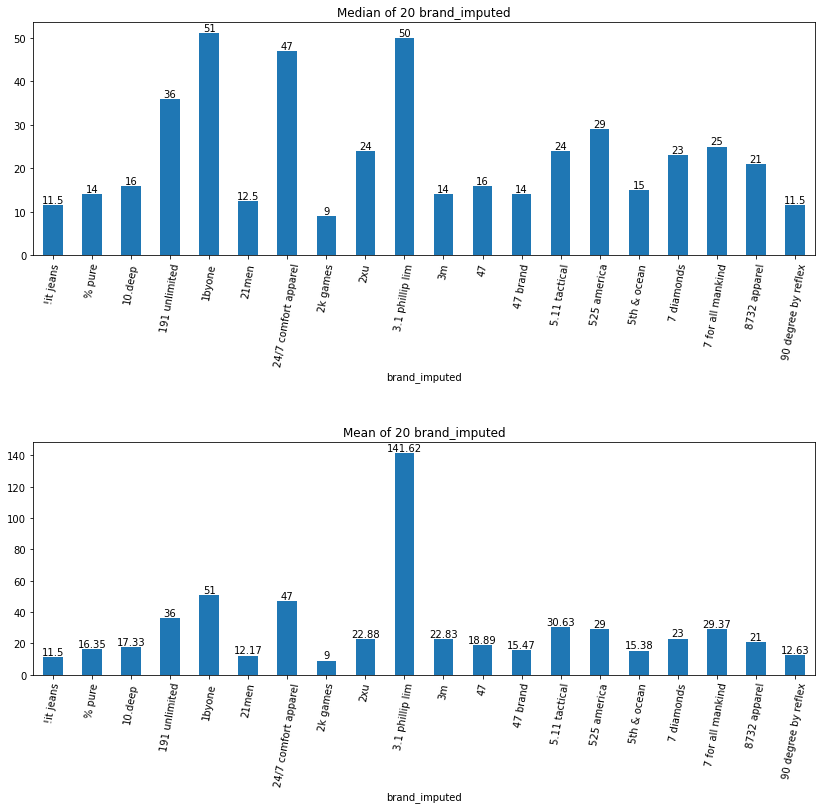

In [332]:
# mean and median price of the first 20 subcategories_1
fig,ax = plt.subplots(2, 1, figsize=(14,12), gridspec_kw={'hspace': 0.8})
# median price
product_listings_mercari.groupby('brand_imputed')['price'].median().round(2)[:20].plot.bar(rot=80, title='Median of 20 brand_imputed', ax=ax[0]) 
# mean price
product_listings_mercari.groupby('brand_imputed')['price'].mean().round(2)[:20].plot.bar(rot=80, title='Mean of 20 brand_imputed', ax=ax[1])

for i in range(len(ax)):
    ax[i].bar_label(ax[i].containers[0])

plt.show()

<AxesSubplot:xlabel='brand_imputed', ylabel='price'>

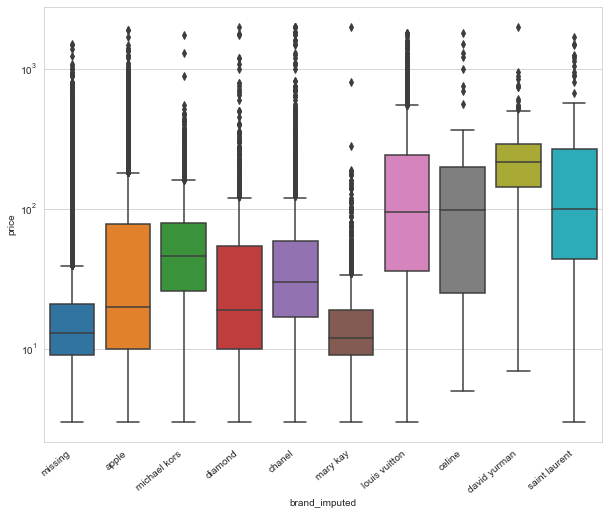

In [335]:
exp_brand = product_listings_mercari.sort_values(by='price', ascending=False)['brand_imputed'].dropna().unique()[:10]

# analyzing expensive brands and price
exp_brands = product_listings_mercari['brand_imputed'].where(product_listings_mercari['brand_imputed'].isin(exp_brand))

# plotting main categories and price
fig, ax =plt.subplots(figsize=(10,8))
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
sns.set_style("whitegrid")
sns.boxplot(y='price', x=exp_brands, data=product_listings_mercari)

<AxesSubplot:title={'center':'Mean Price - Category: home'}, ylabel='brand_imputed'>

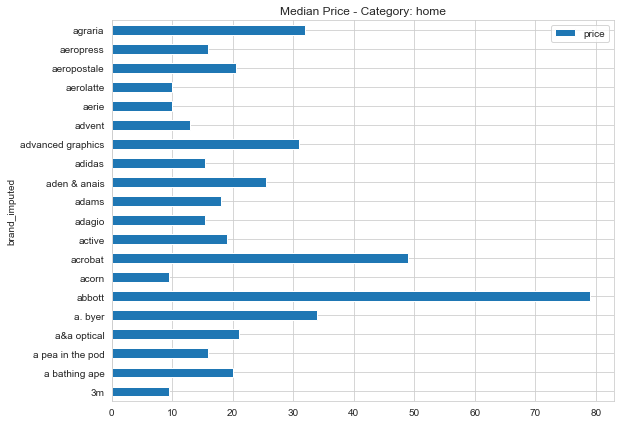

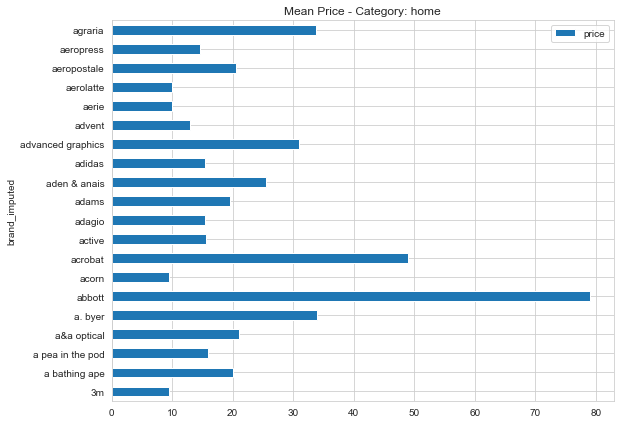

In [350]:
unique_main_cat = product_listings_mercari.main_cat.unique()

category = unique_main_cat[3] # choosing a category from the list

product_listings_mercari[product_listings_mercari['main_cat']==category].groupby('brand_imputed').median()['price'].reset_index()[:20].plot.barh(x='brand_imputed', figsize=(9,7), title='Median Price - Category: %s' %category)
                                                                                                         
product_listings_mercari[product_listings_mercari['main_cat']==category].groupby('brand_imputed').mean()['price'].reset_index()[:20].plot.barh(x='brand_imputed', figsize=(9,7), title='Mean Price - Category: %s' %category)

- there is a high variation in prices based on the brand.
- even within the same category or subcategory the prices then may vary according to the brand

In [311]:
product_listings_mercari.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481661 entries, 0 to 1481660
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1481661 non-null  int64  
 1   name               1481661 non-null  object 
 2   item_condition_id  1481661 non-null  int64  
 3   category_name      1475347 non-null  object 
 4   brand_name         849325 non-null   object 
 5   price              1481661 non-null  float64
 6   shipping           1481661 non-null  int64  
 7   item_description   1481661 non-null  object 
 8   main_cat           1481661 non-null  object 
 9   sub_cat1           1481661 non-null  object 
 10  sub_cat2           1481661 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.3+ MB


In [ ]:
# exporting cleaned dataset for next stage
product_listings_mercari.to_csv(data_path+"mercari_cleaned_brand_imputed.csv", index=False)